## Exploratory Analysis

In this section, we gather more information about the nature of our data. We focus on one stock at a time as each stock's profle can be different. We can find out statistical information like mean, standard deviation. In addition, we can look at the distribution of our data using histograms.

One of the important information we already know is that the closing price is a function of time as it changes everyday, and we have captured  that aspect of the data. Using the time information, we can explore features such as how the data behaves yearly or monthly and look for trend or seasonality patterns.

## Reading the dataset

As an example, we will look at 'BHEL' stock. We read data from the local MongoDB that was set up in the data sourcing step. We only focus on Close price for the exploration for now.

In [30]:
from pymongo import MongoClient
client = MongoClient('mongodb://localhost:27017/?readPreference=primary&appname=MongoDB+Compass&directConnection=true&ssl=false')
filter={}
collection = client['niftyfifty']['stock-data']
bheldata = []
data = collection.find({'Stock': {"$eq" : 'BHEL'}},{'_id':0, 'Date':1, 'Close':1})
bheldata = [d for d in data]


We import the pandas library for data handling. We make a DataFrame object from the BHEL data. df.head() shows the first 5 records.

In [31]:
import pandas as pd
df = pd.DataFrame(bheldata)
df.head()

,Date,Close
0,2021-03-25,48.20
1,2021-03-26,48.70
2,2021-03-30,48.95
3,2021-03-31,48.75
4,2021-04-01,50.95


Next, we make the Date column index to easily extract time related data easily.

In [32]:
df.index = df.Date
df = df.drop('Date',axis=1)
df

,Close
Date,
2021-03-25,48.20
2021-03-26,48.70
2021-03-30,48.95
2021-03-31,48.75
2021-04-01,50.95
...,...
2022-03-16,51.20
2022-03-17,51.40
2022-03-21,50.70


We use the describe function provided on a DataFrame object. It tells us that there are 246 records for BHEL from 25th March of, 2021 to 23rd March, 2022. We can also see the mean, min and max of the data. These values will be different for different stocks as stock prices can be very varied. 

In [33]:
df.describe()

,Close
count,246.000000
mean,60.244309
std,7.923283
min,44.050000
25%,54.462500
50%,60.050000
75%,65.637500
max,77.000000


We can plot a histogram or kde (density plot) to see the distribution of the data.

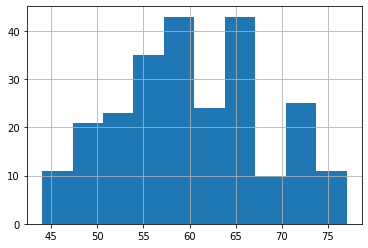

In [39]:
from matplotlib import pyplot

df.Close.hist()
pyplot.show()

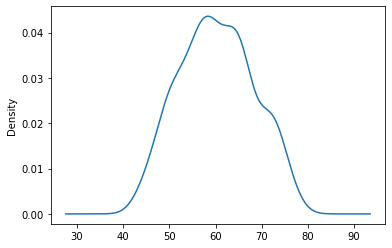

In [40]:
df.Close.plot(kind='kde')
pyplot.show()

The graph mostly resembles a bell curve which suggests normal distribution. However, is centered around mean 60 and standard deviation is not 1. Thus, we can normalize it to get better results.

## Feature engineering

In this step we explore the different information we can extract from just the date and the closing price. We can get month and day information which can tell us about monthly fluctuations or seasonal ups and downs. 

In [7]:
datetimefeatures = pd.DataFrame()
datetimefeatures['month'] = [df.index[i].month for i in range(len(df))]
datetimefeatures['day'] = [df.index[i].day for i in range(len(df))]
datetimefeatures['Close'] = [df.Close[i] for i in range(len(df))]
print(datetimefeatures.head(5))

   month  day  Close
0      3   25  48.20
1      3   26  48.70
2      3   30  48.95
3      3   31  48.75
4      4    1  50.95


We can also get lag values as it is a time series and a value can depend on previous values. We can use scatter plots to find if there is correlation between a day's closing price and its lag values:

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

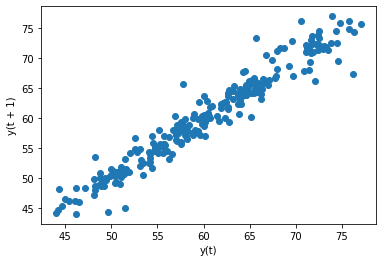

In [35]:
from pandas.plotting import lag_plot
series = df.Close
lag_plot(series)

As we can see, the points crowd around the diagonal, which indicates that there is an association between a value and its lag. We can do it for multiple lag values as shown below. Therefore, it makes sense to include these values as features when doing regression or time series forecasting.

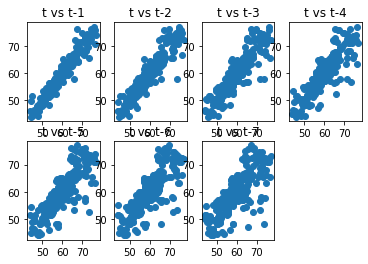

In [27]:
lags = 7
columns = [df]
for i in range(1,(lags + 1)):
    columns.append(df.shift(i))
dataframe = pd.concat(columns, axis=1)
columns = ['t']
for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))
dataframe.columns = columns
pyplot.figure(1)
for i in range(1,(lags + 1)):
    ax = pyplot.subplot(240 + i)
    ax.set_title('t vs t-' + str(i))
    pyplot.scatter(x=dataframe['t'].values, y=dataframe['t-'+str(i)].values)
pyplot.show()

We can get an idea about the number of lags that we can take as features using an autocorrelation plot. It shows the correlation as a function of lag value. A value closer to 0 indicates no correlation and a value closer to 1 or -1 indicates strong correlation. The cutoff is shown in the plot using dashed lines. Above distance 0.25, we can consider strong correlation. From the graph below, we can also see that correlation goes down in a wave. This indicates that there is a seasonality factor in the data.

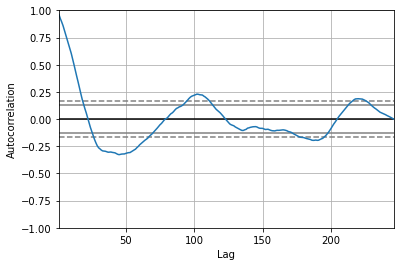

In [36]:
from pandas.plotting import autocorrelation_plot

series = df.Close
autocorrelation_plot(series)
tpyplot.show()

Thus, we can make new features using the lag values. Here, we take last 3 lag values as features. This reduces the amount of data we can use as the first 3 rows have NAN values

In [37]:
lagfeatures = pd.concat([temp.shift(3),temp.shift(2),temp.shift(1), temp], axis=1)
lagfeatures.columns = ['t-2','t-1','t', 't+1']
print(lagfeatures.head(5))

             t-2    t-1      t    t+1
Date                                 
2021-03-25   NaN    NaN    NaN  48.20
2021-03-26   NaN    NaN  48.20  48.70
2021-03-30   NaN  48.20  48.70  48.95
2021-03-31  48.2  48.70  48.95  48.75
2021-04-01  48.7  48.95  48.75  50.95


We can also make new features using mean, min and max values. Here also, we have to discard some rows due to NAN values 

In [38]:
width = 3
shifted = temp.shift(width - 1)
window = shifted.rolling(window=width)
windowsummary = pd.concat([window.min(), window.mean(), window.max(), temp], axis=1)
windowsummary.columns = ['min', 'mean', 'max', 't+1']
print(windowsummary.head(5))

             min       mean    max    t+1
Date                                     
2021-03-25   NaN        NaN    NaN  48.20
2021-03-26   NaN        NaN    NaN  48.70
2021-03-30   NaN        NaN    NaN  48.95
2021-03-31   NaN        NaN    NaN  48.75
2021-04-01  48.2  48.616667  48.95  50.95


In [11]:
window = temp.expanding()
expwindow = pd.concat([window.min(), window.mean(), window.max(), temp.shift(-1)], axis=1)
expwindow.columns = ['min', 'mean', 'max', 't+1']
print(expwindow.head(5))

             min       mean    max    t+1
Date                                     
2021-03-25  48.2  48.200000  48.20  48.70
2021-03-26  48.2  48.450000  48.70  48.95
2021-03-30  48.2  48.616667  48.95  48.75
2021-03-31  48.2  48.650000  48.95  50.95
2021-04-01  48.2  49.110000  50.95  49.00


## Visualization

Now we will use more plots to understand our data. Below, we use a line plot to see how our data changes over time. We can also dot markers as we can more clearly see our data points.

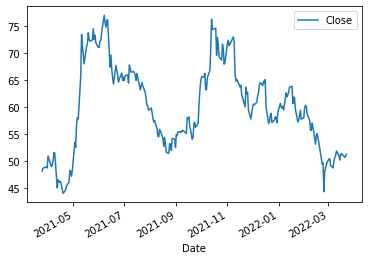

In [42]:

df.plot()
pyplot.show()

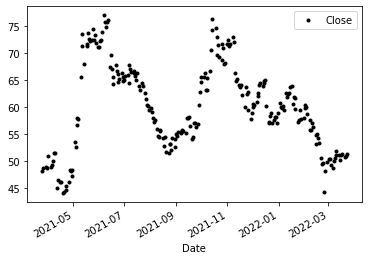

In [43]:
df.plot(style='k.')
pyplot.show()

As we gather more data, we can also group it by year to see the patterns. We can do so using groupby function provided on a pandas Series object.

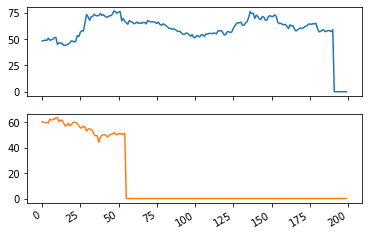

In [44]:
groups = df.Close.groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
length = 200
for name, group in groups:
    val = [group.values[i] if i<len(group.values) else 0 for i in range(length)]
    years[name.year] = val
    
years.plot(subplots=True, legend=False)
pyplot.show()

Box plots can tell us about the range of data and outliers. From below we can see 2021 BHEL values were higher than the current year values. 

<AxesSubplot:>

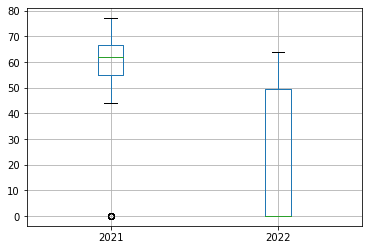

In [45]:
years.boxplot()

We can also see the monthly box plots which can tell us how values behaved as a function of month. The circle points are outliers, we can choose to remove such rows as a data cleaning step

<AxesSubplot:>

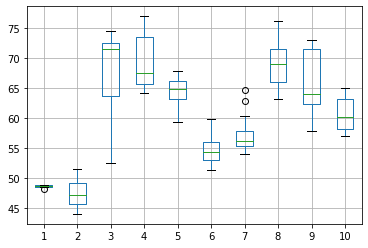

In [46]:
one_year = df['2021']
groups = one_year.groupby(pd.Grouper(freq='M'))
months = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
months = pd.DataFrame(months)
months.columns = range(1,11)
months.boxplot()

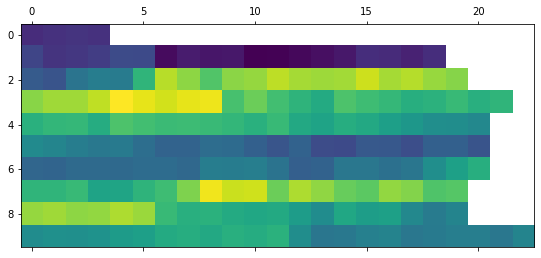

In [47]:
pyplot.matshow(months.T, interpolation=None, aspect='auto')
pyplot.show()

## Smoothing
As stock prices can have a lot of random fluctuations and noise, it is better to smooth them to get better results. One way is to use moving average. We go over the data in a sliding window manner, and replace the centre value by the mean of the window.

Date
2021-03-25         NaN
2021-03-26         NaN
2021-03-30    0.856579
2021-03-31    0.856850
2021-04-01    0.857917
2021-04-05    0.857941
2021-04-06    0.858232
2021-04-07    0.857791
2021-04-08    0.859006
2021-04-09    0.860007
Name: Close, dtype: float64


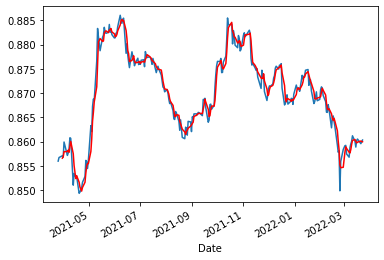

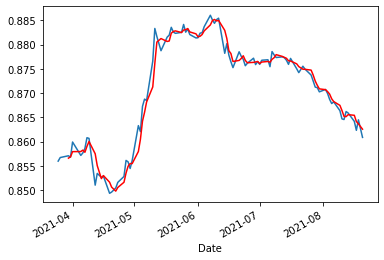

In [56]:
rolling = df.Close.rolling(window=3)
rolling_mean = rolling.mean()
print(rolling_mean.head(10))

series.plot()
rolling_mean.plot(color='red')
pyplot.show()

# Zoomed version
series[:100].plot()
rolling_mean[:100].plot(color='red')
pyplot.show()

In our data, we include EMA or exponential moving average which takes exponential average of periods of 10, 20 and 50 days. This is in addition to the closing prices and acts as smooth version of them. Thus we would not perform an extra smoothening step.

## Conclusion

- In this section, we see that our data has normal distribution but we can normalize it for better results.
- We also explore the time features of the data, and understand that a value has correlation with its previous values. Therefore, we create lag features for our data.
- We also see yearly and monthly behaviour of our data, and use various plots to get an intuition of the nature of our data.

